In [1]:
import pandas as pd
import os

# 定义文件夹路径
info_folder = 'StockData/market_info'
data_folder = 'StockData/market_data'

# 创建字典存储股票相关信息数据
market_info = {}
# 读取 market_info 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_{year}.csv'  # 文件名格式
    file_path = os.path.join(info_folder, file_name)
    if os.path.isfile(file_path):  # 检查文件是否存在
        data = pd.read_csv(file_path)  # 默认读取，自动检测标题
        market_info[f'year_{year}'] = data  # 存储数据到字典中
    else:
        print(f'Warning: File {file_path} does not exist.')

# 创建字典存储股票具体数据
market_data = {}
# 读取 market_data 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_kdata_{year}.csv'  # 文件名格式
    file_path = os.path.join(data_folder, file_name)
    if os.path.isfile(file_path):  # 检查文件是否存在
        data = pd.read_csv(file_path)  # 默认读取，自动检测标题
        market_data[f'year_{year}'] = data  # 存储数据到字典中
    else:
        print(f'Warning: File {file_path} does not exist.')

# 检查导入的数据
print('market_info 数据样例:')
for year in range(2014, 2025):
    if f'year_{year}' in market_info:
        print(f'{year}年数据:')
        print(market_info[f'year_{year}'].head())  # 查看前5行

print('market_data 数据样例:')
for year in range(2014, 2025):
    if f'year_{year}' in market_data:
        print(f'{year}年数据:')
        print(market_data[f'year_{year}'].head())  # 查看前5行

# 合并所有年份的市场数据为一个数据框（可选）
combined_market_data = pd.concat(market_data.values(), ignore_index=True)
print('合并后的市场数据样例:')
print(combined_market_data.head())

# results_df = pd.DataFrame(results)
# results_df.to_csv('pca_results.csv', index=False)

market_info 数据样例:
2014年数据:
   Unnamed: 0         code  name block_name  weight        date
0           0  szse.000001  平安银行       payh     0.0  2013-12-16
1           1  szse.000002   万科A        wka     0.0  2013-12-16
2           2  szse.000009  中国宝安       zgba     0.0  2013-12-16
3           3  szse.000012   南玻A        nba     0.0  2013-12-16
4           4  szse.000024  招商地产       zsdc     0.0  2013-12-16
2015年数据:
   Unnamed: 0         code  name block_name  weight        date
0           0  szse.000001  平安银行       payh  0.0107  2014-12-31
1           1  szse.000002   万科A        wka  0.0160  2014-12-31
2           2  szse.000009  中国宝安       zgba  0.0023  2014-12-31
3           3  szse.000024  招商地产       zsdc  0.0032  2014-12-31
4           4  szse.000027  深圳能源       szny  0.0011  2014-12-31
2016年数据:
   Unnamed: 0         code  name block_name   weight        date
0           0  szse.000001  平安银行       payh  0.00698  2015-12-31
1           1  szse.000002   万科A        wka  0.01929  201

警告：有无法解析的时间格式，已被设置为缺失值。


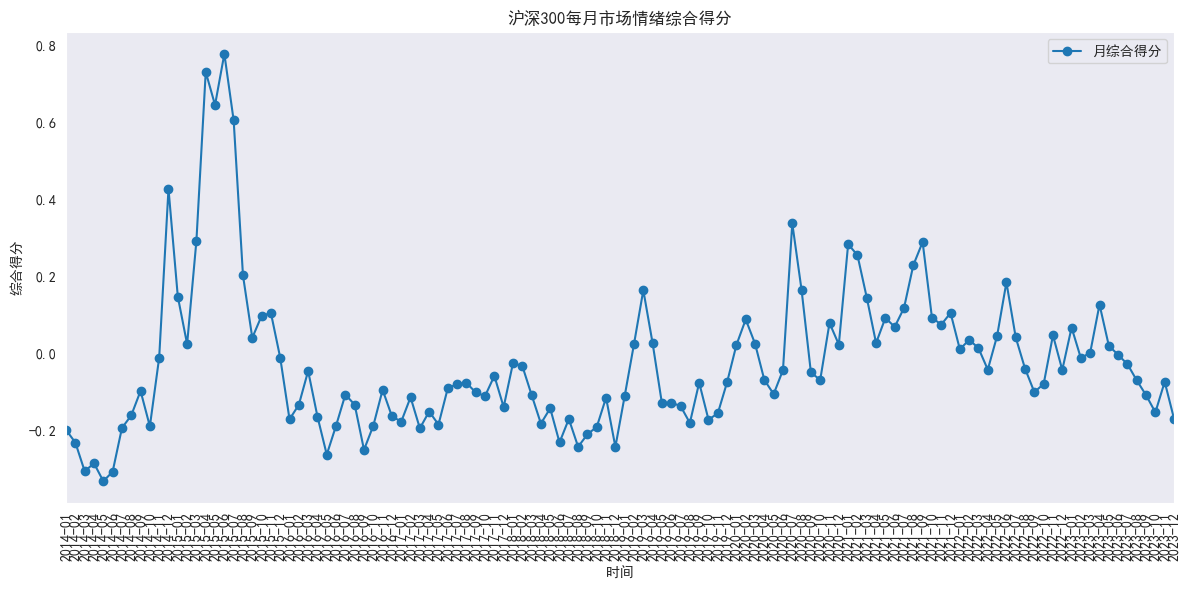

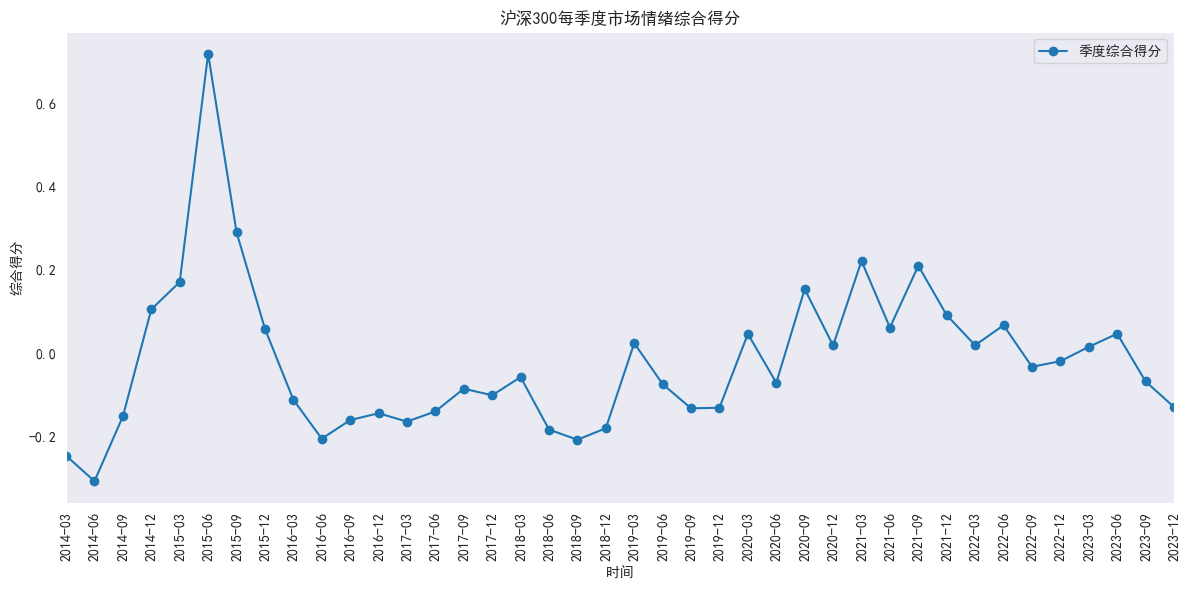

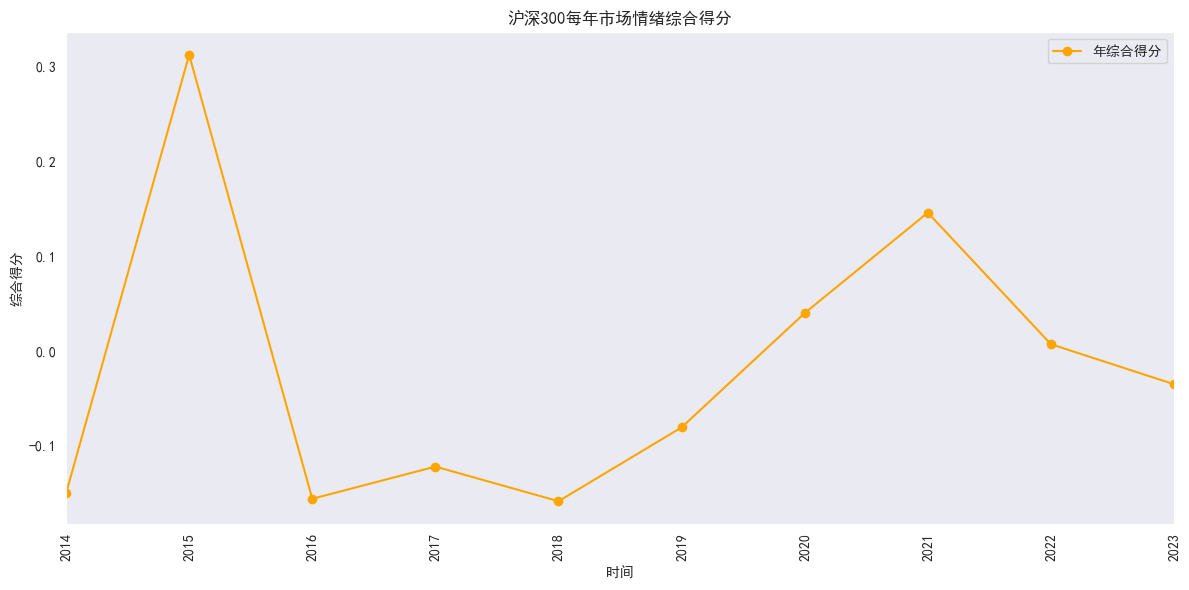

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

# 忽略 FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 设置matplotlib支持中文显示
matplotlib.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设之前已经合并了市场数据到combined_market_data
# combined_market_data = pd.concat(market_data.values(), ignore_index=True)

# 确保选择合适的窗口大小 N
N = 10  # 可以根据需要进行调整

# 计算市场市值
combined_market_data['market_cap'] = combined_market_data['close'] * combined_market_data['volume']

# 1. 换手率
combined_market_data['TURNOVER'] = combined_market_data['amount'] / combined_market_data['market_cap']

# 2. 心理线
combined_market_data['PSY'] = (combined_market_data['close'].diff() > 0).rolling(window=N).mean() * 100

# 3. 成交量
combined_market_data['VOLUME'] = combined_market_data['volume'].rolling(window=N).sum()

# 4. 成交金额
combined_market_data['MONEY'] = combined_market_data['amount'].rolling(window=N).sum()

# 5. 涨跌幅
combined_market_data['CHAC'] = (combined_market_data['close'] - combined_market_data['open']) / combined_market_data['open'] * 100

# 标准化
for col in ['TURNOVER', 'PSY', 'VOLUME', 'MONEY', 'CHAC']:
    combined_market_data[f'Z_{col}'] = (combined_market_data[col] - combined_market_data[col].mean()) / combined_market_data[col].std()

# 自定义权重
weights = [-0.0476, 0.1509, 0.3693, 0.3938, 0.0384]

# 复合指标
combined_market_data['Composite_Score'] = (weights[0] * combined_market_data['Z_TURNOVER'] +
                                            weights[1] * combined_market_data['Z_PSY'] +
                                            weights[2] * combined_market_data['Z_VOLUME'] +
                                            weights[3] * combined_market_data['Z_MONEY'] +
                                            weights[4] * combined_market_data['Z_CHAC'])

# 检查时间列是否存在
if 'time' in combined_market_data.columns:
    # 尝试将时间列转换为日期格式，允许多种格式
    combined_market_data['date'] = pd.to_datetime(combined_market_data['time'], errors='coerce')

    # 检查是否存在缺失值
    if combined_market_data['date'].isnull().any():
        print("警告：有无法解析的时间格式，已被设置为缺失值。")

    combined_market_data.set_index('date', inplace=True)

    # 按月汇总综合得分
    monthly_scores = combined_market_data['Composite_Score'].resample('M').mean()
    # 按季度汇总综合得分
    quarterly_scores = combined_market_data['Composite_Score'].resample('Q').mean()
    # 按年份汇总综合得分
    yearly_scores = combined_market_data['Composite_Score'].resample('Y').mean()

    # 可视化每月综合得分
    plt.figure(figsize=(12, 6))  # 设置展示窗口的长宽
    monthly_scores.plot(title='沪深300每月市场情绪综合得分', marker='o', label='月综合得分')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.xticks(monthly_scores.index, monthly_scores.index.strftime('%Y-%m'), rotation=90)  # 设置X轴为按月份展示
    plt.grid()
    plt.legend()
    plt.tight_layout()  # 自适应布局
    plt.show()
    
     # 可视化每季度综合得分
    plt.figure(figsize=(12, 6))  # 设置展示窗口的长宽
    quarterly_scores.plot(title='沪深300每季度市场情绪综合得分', marker='o', label='季度综合得分')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.xticks(quarterly_scores.index, quarterly_scores.index.strftime('%Y-%m'), rotation=90)  # 设置X轴为按季度展示
    plt.grid()
    plt.legend()
    plt.tight_layout()  # 自适应布局
    plt.show()

    # 可视化每年综合得分
    plt.figure(figsize=(12, 6))  # 设置展示窗口的长宽
    yearly_scores.plot(title='沪深300每年市场情绪综合得分', marker='o', color='orange', label='年综合得分')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.xticks(yearly_scores.index, yearly_scores.index.strftime('%Y'), rotation=90)  # 设置X轴为按年份展示
    plt.grid()
    plt.legend()
    plt.tight_layout()  # 自适应布局
    plt.show()
    
    # 计算描述性统计
    descriptive_stats = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].describe().T
    descriptive_stats['偏度'] = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].skew()
    descriptive_stats['峰度'] = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].kurt()

    # 选择所需的描述性统计指标
    descriptive_stats = descriptive_stats[['min', 'max', 'mean', 'std', '偏度', '峰度']]
    descriptive_stats.columns = ['最小值', '最大值', '平均值', '标准差', '偏度', '峰度']

    # 计算相关性矩阵
    correlation_matrix = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].corr()

    # 保存结果为xlsx文件
    with pd.ExcelWriter('市场情绪代理变量分析.xlsx') as writer:
        descriptive_stats.to_excel(writer, sheet_name='描述性统计')
        correlation_matrix.to_excel(writer, sheet_name='相关性矩阵')
else:
    print("错误：时间列'time'不存在，请检查数据。")

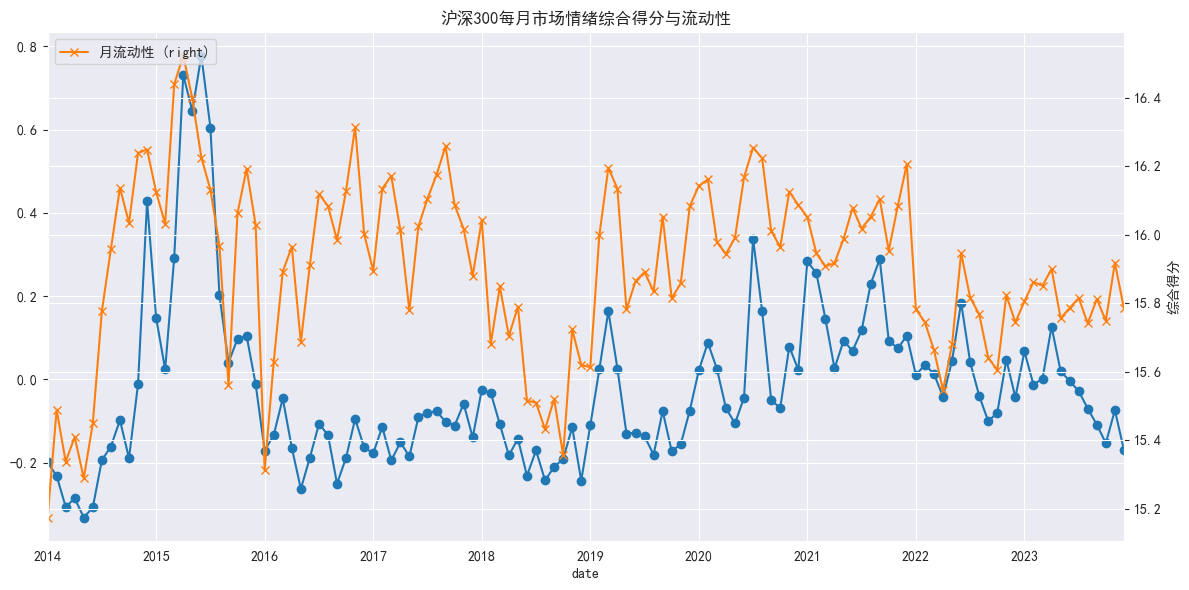

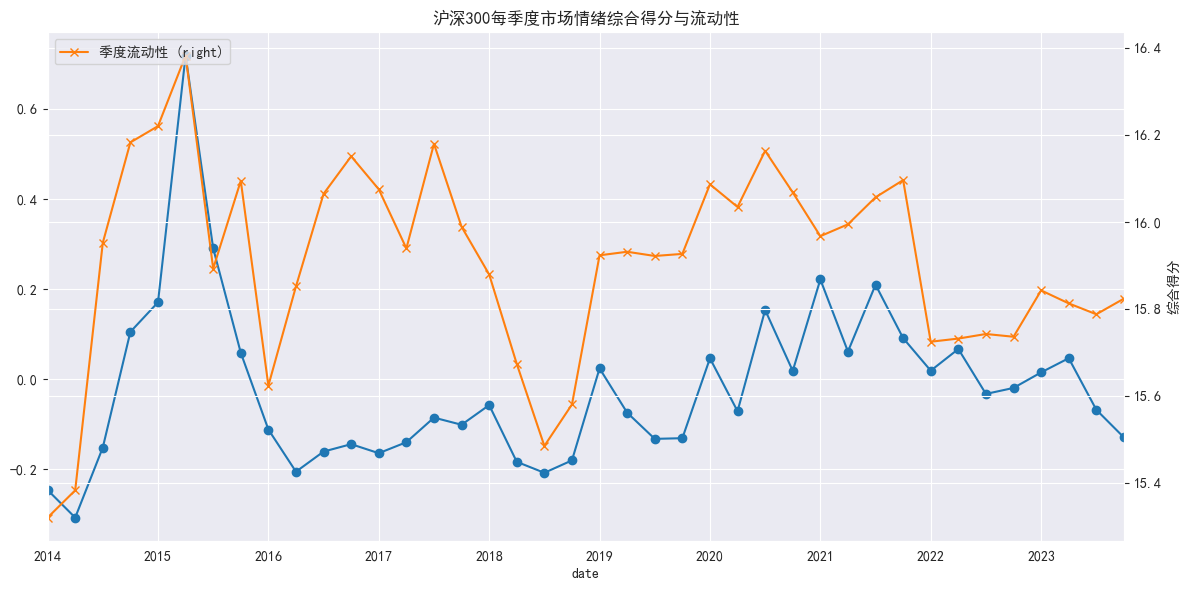

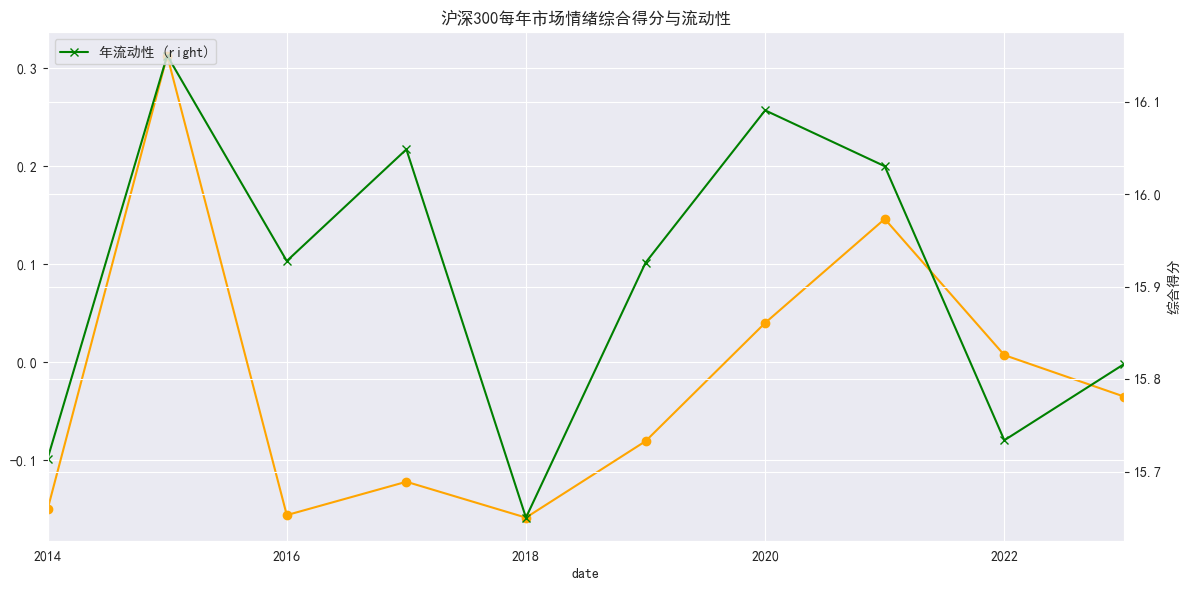

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings

# 忽略 FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 设置matplotlib支持中文显示
matplotlib.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设之前已经合并了市场数据到combined_market_data
# combined_market_data = pd.concat(market_data.values(), ignore_index=True)

# 确保选择合适的窗口大小 N
N = 10  # 可以根据需要进行调整

# 计算市场市值
combined_market_data['market_cap'] = combined_market_data['close'] * combined_market_data['volume']

# 1. 换手率
combined_market_data['TURNOVER'] = combined_market_data['amount'] / combined_market_data['market_cap']

# 2. 心理线
combined_market_data['PSY'] = (combined_market_data['close'].diff() > 0).rolling(window=N).mean() * 100

# 3. 成交量
combined_market_data['VOLUME'] = combined_market_data['volume'].rolling(window=N).sum()

# 4. 成交金额
combined_market_data['MONEY'] = combined_market_data['amount'].rolling(window=N).sum()

# 5. 涨跌幅
combined_market_data['CHAC'] = (combined_market_data['close'] - combined_market_data['open']) / combined_market_data['open'] * 100

# 标准化
for col in ['TURNOVER', 'PSY', 'VOLUME', 'MONEY', 'CHAC']:
    combined_market_data[f'Z_{col}'] = (combined_market_data[col] - combined_market_data[col].mean()) / combined_market_data[col].std()

# 自定义权重
weights = [-0.0476, 0.1509, 0.3693, 0.3938, 0.0384]

# 复合指标
combined_market_data['Composite_Score'] = (weights[0] * combined_market_data['Z_TURNOVER'] +
                                            weights[1] * combined_market_data['Z_PSY'] +
                                            weights[2] * combined_market_data['Z_VOLUME'] +
                                            weights[3] * combined_market_data['Z_MONEY'] +
                                            weights[4] * combined_market_data['Z_CHAC'])

# 市场流动性计算函数
def calculate_market_liquidity(data, epsilon=1e-10):
    price_spread = np.log((data['high'] + epsilon) / (data['low'] + epsilon))
    data['liquidity'] = np.log(1 + (data['volume'] / price_spread))
    data['liquidity'].replace([np.inf, -np.inf], np.nan, inplace=True)
    return data['liquidity']

# 应用流动性计算函数
combined_market_data['Liquidity'] = calculate_market_liquidity(combined_market_data)

# 检查时间列是否存在
if 'time' in combined_market_data.columns:
    # 将时间列转换为日期格式
    combined_market_data['date'] = pd.to_datetime(combined_market_data['time'], errors='coerce')
    combined_market_data.set_index('date', inplace=True)

    # 按月、季度和年度汇总综合得分和流动性
    monthly_scores = combined_market_data[['Composite_Score', 'Liquidity']].resample('M').mean()
    quarterly_scores = combined_market_data[['Composite_Score', 'Liquidity']].resample('Q').mean()
    yearly_scores = combined_market_data[['Composite_Score', 'Liquidity']].resample('Y').mean()

    # 可视化每月综合得分和流动性
    plt.figure(figsize=(12, 6))
    monthly_scores['Composite_Score'].plot(marker='o', label='月综合得分')
    monthly_scores['Liquidity'].plot(marker='x', label='月流动性', secondary_y=True)
    plt.title('沪深300每月市场情绪综合得分与流动性')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.grid()
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # 可视化每季度综合得分和流动性
    plt.figure(figsize=(12, 6))
    quarterly_scores['Composite_Score'].plot(marker='o', label='季度综合得分')
    quarterly_scores['Liquidity'].plot(marker='x', label='季度流动性', secondary_y=True)
    plt.title('沪深300每季度市场情绪综合得分与流动性')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.grid()
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # 可视化每年综合得分和流动性
    plt.figure(figsize=(12, 6))
    yearly_scores['Composite_Score'].plot(marker='o', color='orange', label='年综合得分')
    yearly_scores['Liquidity'].plot(marker='x', color='green', label='年流动性', secondary_y=True)
    plt.title('沪深300每年市场情绪综合得分与流动性')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.grid()
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # 计算描述性统计
    descriptive_stats = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC', 'Liquidity']].describe().T
    descriptive_stats['偏度'] = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC', 'Liquidity']].skew()
    descriptive_stats['峰度'] = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC', 'Liquidity']].kurt()

    # 选择所需的描述性统计指标
    descriptive_stats = descriptive_stats[['min', 'max', 'mean', 'std', '偏度', '峰度']]
    descriptive_stats.columns = ['最小值', '最大值', '平均值', '标准差', '偏度', '峰度']

    # 计算相关性矩阵
    correlation_matrix = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC', 'Liquidity']].corr()

    # 保存结果为xlsx文件
    with pd.ExcelWriter('市场情绪与流动性分析.xlsx') as writer:
        descriptive_stats.to_excel(writer, sheet_name='描述性统计')
        correlation_matrix.to_excel(writer, sheet_name='相关性矩阵')
else:
    print("错误：时间列'time'不存在，请检查数据。")


警告：有无法解析的时间格式，已被设置为缺失值。


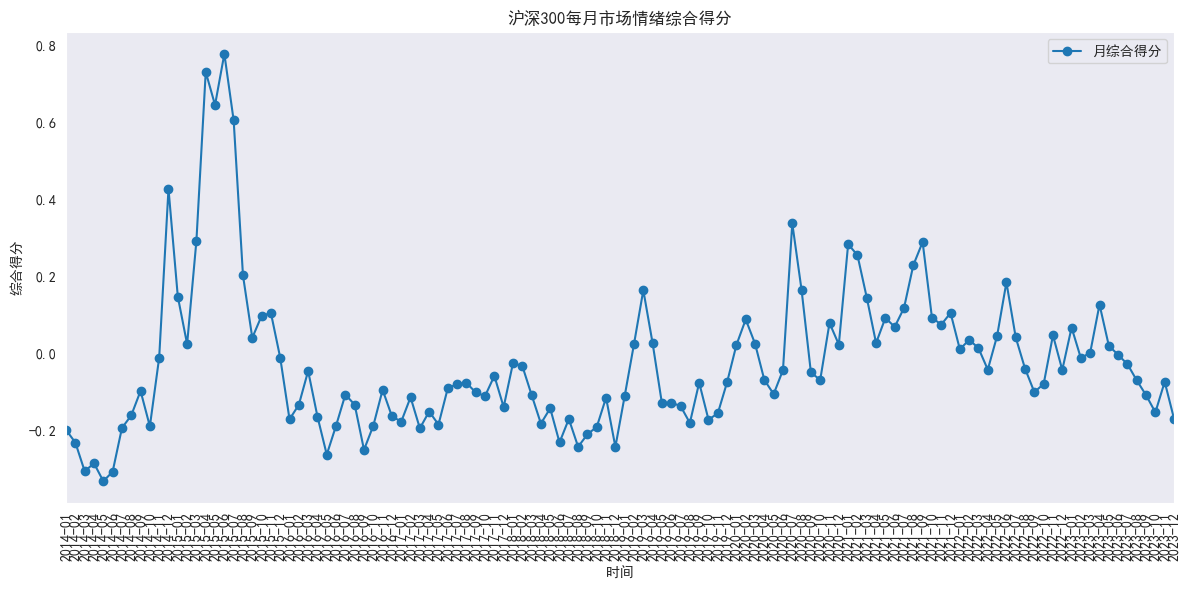

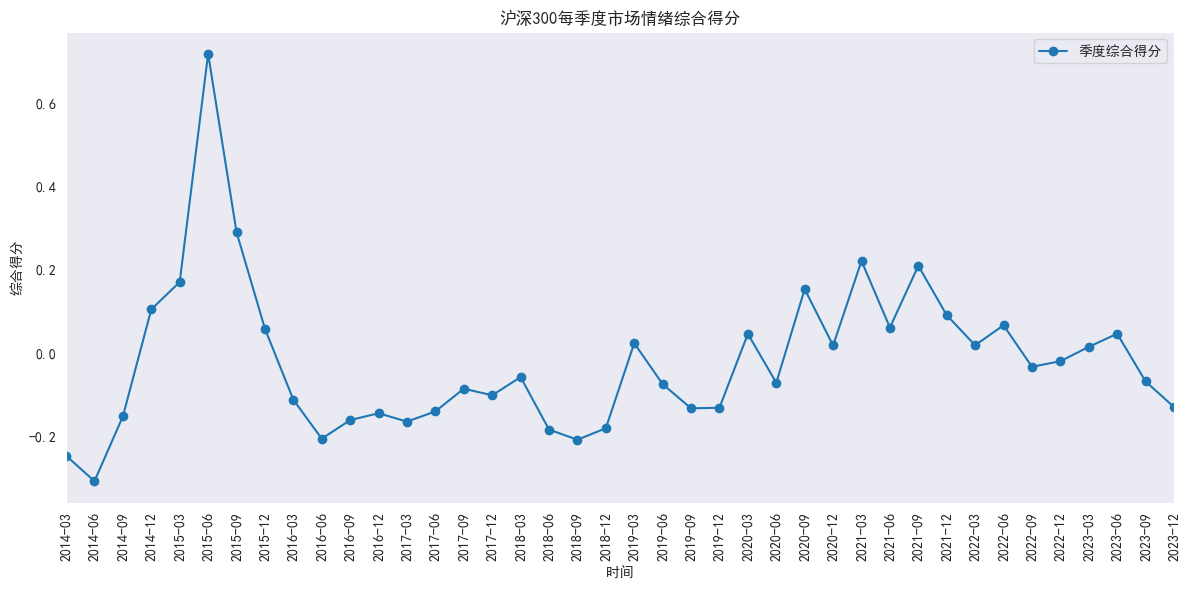

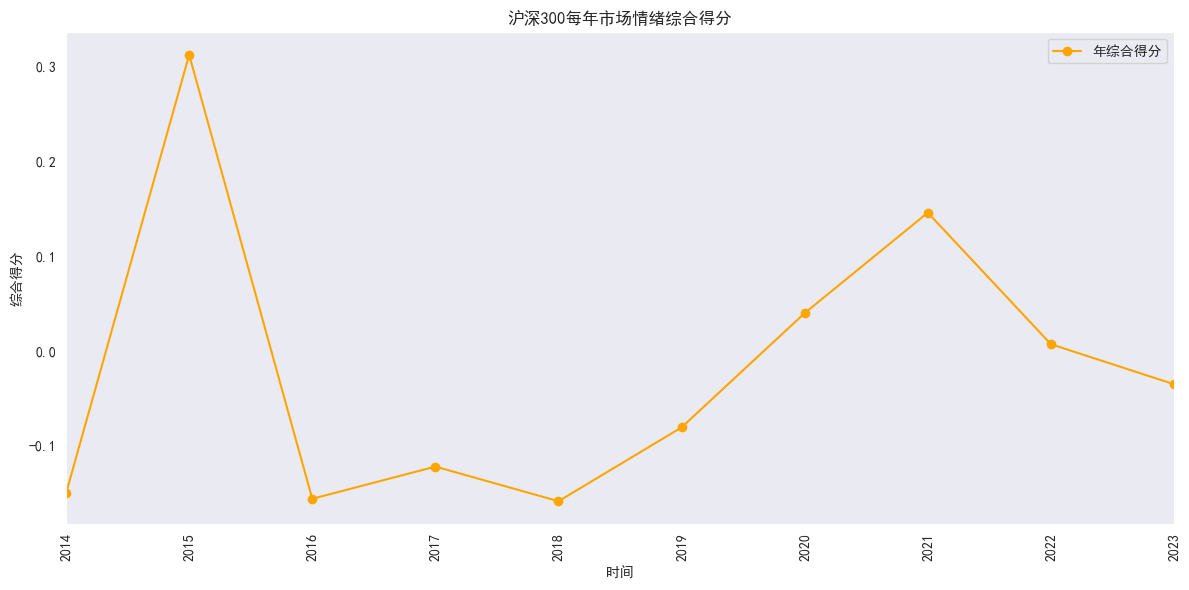

C:\Users\liang\AppData\Local\Temp\ipykernel_18120\430928076.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return'] = data['close'].pct_change()  # 计算日收益率
C:\Users\liang\AppData\Local\Temp\ipykernel_18120\430928076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['abs_return'] = data['return'].abs()  # 计算绝对日收益率
C:\Users\liang\AppData\Local\Temp\ipykernel_18120\430928076.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

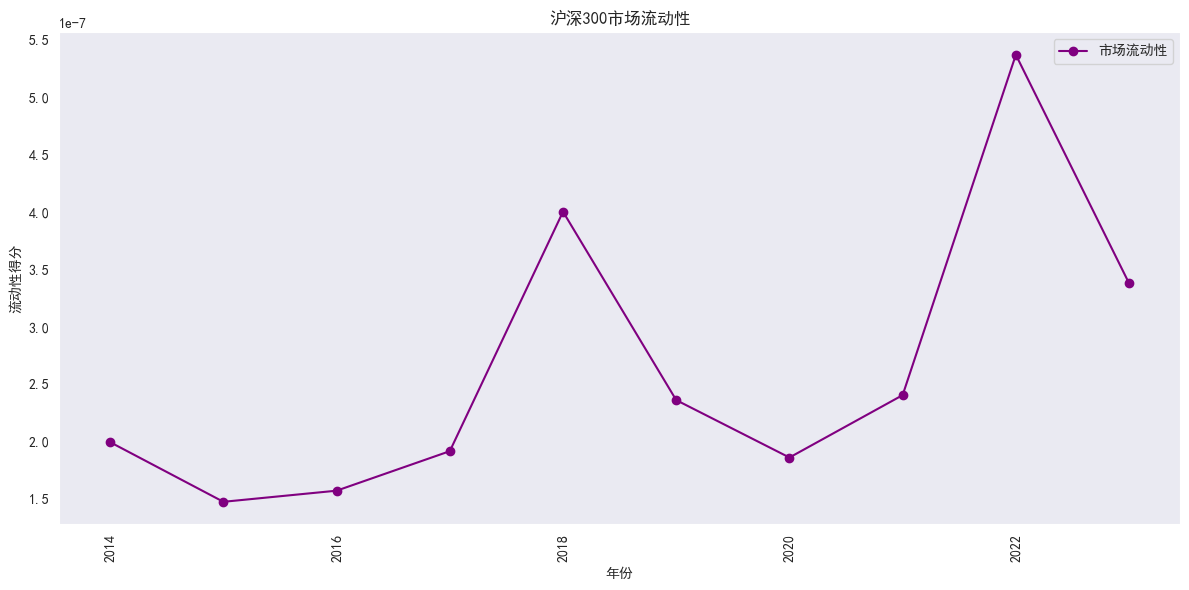

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings

# 忽略 FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 设置matplotlib支持中文显示
matplotlib.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 市场流动性计算函数
def calculate_stock_illiquidity6(market_data):
    liquidity = {}
    for year, data in market_data.items():
        # Ensure 'return', 'volume', and 'date' columns are in the data
        data['return'] = data['close'].pct_change()  # 计算日收益率
        data['abs_return'] = data['return'].abs()  # 计算绝对日收益率
        data['illiquidity'] = data['abs_return'] / data['volume']  # 每日illiquidity

        # 计算年平均流动性
        avg_illiquidity = data['illiquidity'].mean()  # 计算平均illiquidity
        liquidity[year] = avg_illiquidity

    return liquidity

# 假设之前已经合并了市场数据到combined_market_data
# combined_market_data = pd.concat(market_data.values(), ignore_index=True)

# 确保选择合适的窗口大小 N
N = 10  # 可以根据需要进行调整

# 计算市场市值
combined_market_data['market_cap'] = combined_market_data['close'] * combined_market_data['volume']

# 1. 换手率
combined_market_data['TURNOVER'] = combined_market_data['amount'] / combined_market_data['market_cap']

# 2. 心理线
combined_market_data['PSY'] = (combined_market_data['close'].diff() > 0).rolling(window=N).mean() * 100

# 3. 成交量
combined_market_data['VOLUME'] = combined_market_data['volume'].rolling(window=N).sum()

# 4. 成交金额
combined_market_data['MONEY'] = combined_market_data['amount'].rolling(window=N).sum()

# 5. 涨跌幅
combined_market_data['CHAC'] = (combined_market_data['close'] - combined_market_data['open']) / combined_market_data['open'] * 100

# 标准化
for col in ['TURNOVER', 'PSY', 'VOLUME', 'MONEY', 'CHAC']:
    combined_market_data[f'Z_{col}'] = (combined_market_data[col] - combined_market_data[col].mean()) / combined_market_data[col].std()

# 自定义权重
weights = [-0.0476, 0.1509, 0.3693, 0.3938, 0.0384]

# 复合指标
combined_market_data['Composite_Score'] = (weights[0] * combined_market_data['Z_TURNOVER'] +
                                            weights[1] * combined_market_data['Z_PSY'] +
                                            weights[2] * combined_market_data['Z_VOLUME'] +
                                            weights[3] * combined_market_data['Z_MONEY'] +
                                            weights[4] * combined_market_data['Z_CHAC'])

# 检查时间列是否存在
if 'time' in combined_market_data.columns:
    # 尝试将时间列转换为日期格式，允许多种格式
    combined_market_data['date'] = pd.to_datetime(combined_market_data['time'], errors='coerce')

    # 检查是否存在缺失值
    if combined_market_data['date'].isnull().any():
        print("警告：有无法解析的时间格式，已被设置为缺失值。")

    combined_market_data.set_index('date', inplace=True)

    # 按月汇总综合得分
    monthly_scores = combined_market_data['Composite_Score'].resample('M').mean()
    # 按季度汇总综合得分
    quarterly_scores = combined_market_data['Composite_Score'].resample('Q').mean()
    # 按年份汇总综合得分
    yearly_scores = combined_market_data['Composite_Score'].resample('Y').mean()

    # 可视化每月综合得分
    plt.figure(figsize=(12, 6))
    monthly_scores.plot(title='沪深300每月市场情绪综合得分', marker='o', label='月综合得分')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.xticks(monthly_scores.index, monthly_scores.index.strftime('%Y-%m'), rotation=90)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 可视化每季度综合得分
    plt.figure(figsize=(12, 6))
    quarterly_scores.plot(title='沪深300每季度市场情绪综合得分', marker='o', label='季度综合得分')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.xticks(quarterly_scores.index, quarterly_scores.index.strftime('%Y-%m'), rotation=90)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 可视化每年综合得分
    plt.figure(figsize=(12, 6))
    yearly_scores.plot(title='沪深300每年市场情绪综合得分', marker='o', color='orange', label='年综合得分')
    plt.xlabel('时间')
    plt.ylabel('综合得分')
    plt.xticks(yearly_scores.index, yearly_scores.index.strftime('%Y'), rotation=90)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 流动性指标计算并可视化
    market_data_by_year = {year: combined_market_data[combined_market_data.index.year == year] for year in combined_market_data.index.year.unique()}
    liquidity_scores = calculate_stock_illiquidity6(market_data_by_year)

    # 将流动性结果转为Series以便作图
    liquidity_series = pd.Series(liquidity_scores)

    # 可视化流动性
    plt.figure(figsize=(12, 6))
    liquidity_series.plot(title='沪深300市场流动性', marker='o', color='purple', label='市场流动性')
    plt.xlabel('年份')
    plt.ylabel('流动性得分')
    plt.xticks(rotation=90)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 计算描述性统计
    descriptive_stats = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].describe().T
    descriptive_stats['偏度'] = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].skew()
    descriptive_stats['峰度'] = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].kurt()

    # 选择所需的描述性统计指标
    descriptive_stats = descriptive_stats[['min', 'max', 'mean', 'std', '偏度', '峰度']]
    descriptive_stats.columns = ['最小值', '最大值', '平均值', '标准差', '偏度', '峰度']

    # 计算相关性矩阵
    correlation_matrix = combined_market_data[['VOLUME', 'MONEY', 'TURNOVER', 'PSY', 'CHAC']].corr()

    # 保存结果为xlsx文件
    with pd.ExcelWriter('市场情绪和流动性分析.xlsx') as writer:
        descriptive_stats.to_excel(writer, sheet_name='描述性统计')
        correlation_matrix.to_excel(writer, sheet_name='相关性矩阵')
        liquidity_series.to_excel(writer, sheet_name='流动性得分')
else:
    print("错误：时间列'time'不存在，请检查数据。")


主成分方差贡献:
主成分 1: 方差贡献 = 0.2504
主成分 2: 方差贡献 = 0.2358
主成分 3: 方差贡献 = 0.1970
主成分 4: 方差贡献 = 0.1668
主成分 5: 方差贡献 = 0.1500


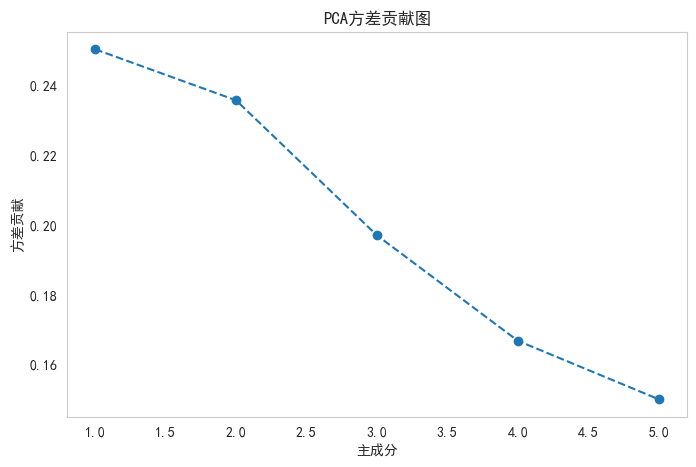

指标权重:
TURNOVER: 权重 = 0.0155
PSY: 权重 = 0.3155
VOLUME: 权重 = 0.1590
MONEY: 权重 = 0.2363
CHAC: 权重 = 0.2737


In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
import warnings

# 忽略 FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 设置matplotlib支持中文显示
matplotlib.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设之前已经合并了市场数据到combined_market_data
# combined_market_data = pd.concat(market_data.values(), ignore_index=True)

# 计算各个指标（确保已计算完这些指标）
# ... 在这里假设已经有了 TURNOVER, PSY, VOLUME, MONEY, CHAC

# 选择要用于PCA的指标
indicators = combined_market_data[['TURNOVER', 'PSY', 'VOLUME', 'MONEY', 'CHAC']].dropna()

# 数据标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(indicators)

# 执行PCA
pca = PCA()
pca.fit(scaled_data)

# 查看每个主成分的方差贡献（解释方差比例）
explained_variance = pca.explained_variance_ratio_

# 打印每个主成分的方差贡献
print('主成分方差贡献:')
variance_results = []  # 初始化结果列表
for i, variance in enumerate(explained_variance):
    result = {'主成分': i + 1, '方差贡献': variance}
    variance_results.append(result)  # 将结果添加到列表中
    print(f'主成分 {i + 1}: 方差贡献 = {variance:.4f}')

# 绘制方差贡献图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('PCA方差贡献图')
plt.xlabel('主成分')
plt.ylabel('方差贡献')
plt.grid()
plt.show()

# 计算每个指标的权重
# 取第一个主成分的载荷（loading）作为指标的权重
loadings = pca.components_[0]

# 将权重标准化，使得总和为1
weights = loadings / np.sum(np.abs(loadings))

# 打印每个指标的权重
weight_df = pd.DataFrame({'指标': indicators.columns, '权重': weights})
print('指标权重:')
weight_results = []  # 初始化权重结果列表
for index, row in weight_df.iterrows():
    result = {'指标': row['指标'], '权重': row['权重']}
    weight_results.append(result)  # 将结果添加到列表中
    print(f"{row['指标']}: 权重 = {row['权重']:.4f}")

# 保存所有结果到一个列表
results = {
    '方差贡献': variance_results,
    '指标权重': weight_results
}
# 如果需要，可以将结果转换为DataFrame并保存到文件
# results_df = pd.DataFrame(results)
# results_df.to_csv('pca_results.csv', index=False)